# Reading the ROOT files

In [418]:
# %matplotlib notebook

In [1]:
import uproot
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import awkward as ak

In [3]:
from scipy.ndimage import median as med

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 
import IPython
from matplotlib import cm

In [5]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [4]:
fastn = uproot.open('data/fastn.root'+':data')
sing = uproot.open('data/singles.root'+':data')
eplus = uproot.open('data/e+.root'+':data')
eminus = uproot.open('data/e-.root'+':data')
fastnsing = uproot.open('data/fastn_singles.root'+':data')

In [5]:
neutrons = fastn.arrays(library='awkward')
singles = sing.arrays(library='awkward')#[:20000]
positrons = eplus.arrays(library='awkward')#[:20000]
electrons = eminus.arrays(library='awkward')
# singles['channel']=singles['channel']-1 #need to reprocess..

In [6]:
nsing = fastnsing.arrays(library='awkward')
moresingles = nsing[nsing['code']==4]
moreneutrons = nsing[nsing['code']==2]

In [7]:
singles = ak.concatenate([singles, moresingles])
neutrons = ak.concatenate([neutrons, moreneutrons])

In [29]:
# Time-sort all the data arrays for recurrent/sequential purposes. 
for j, data in enumerate([neutrons, singles, positrons]):
    print('set %i of %i'%(j+1, 3))
    args = ak.argsort(data['hittime'])
    for key in ['hittime', 'pmtcharge', 'channel']:
        data[key] = data[key][args]

set 1 of 3
set 2 of 3
set 3 of 3


In [56]:
db = DBSCAN(eps=1, min_samples=2).fit(xyz/100)
labels = db.labels_

In [57]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels))
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X, labels))

Estimated number of clusters: 6
Estimated number of noise points: 16


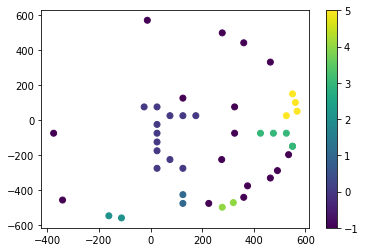

In [65]:
plt.scatter(xyz[:,0], xyz[:,1], c=labels)
plt.colorbar()

In [6]:
what = uproot.open('data/fastn.root'+':runSummary')
smth = what['xyz']
pmtpositions = smth.arrays(library='np')['xyz']
thing = pmtpositions[0][:-1]
whatis = thing.reshape((2330,3))
np.savetxt('pmtpositions.csv', whatis, delimiter=',')

In [135]:
whatis[2329]

array([ 567.7695 ,  -50.37666, -526.     ], dtype=float32)

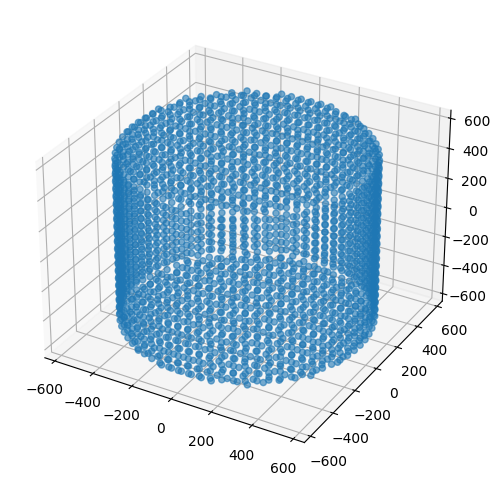

In [7]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(whatis[:,0], whatis[:,1], whatis[:,2], alpha=.6)
plt.show()

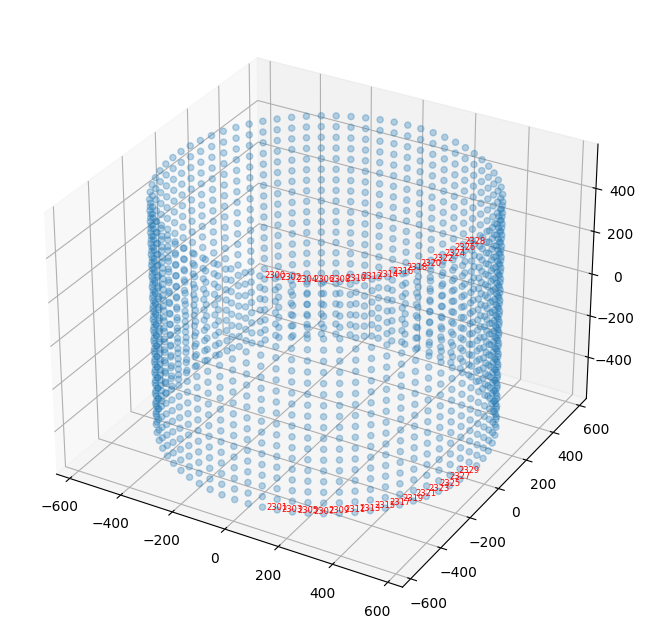

In [137]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(whatis[768:2329,0], whatis[768:2329,1], whatis[768:2329,2], alpha=.3)
for i in range(2300, 2330):
#     print(i)
    ax.text(whatis[i,0], whatis[i,1], whatis[i,2], str(i), 
            color='red', fontsize=6, ha='center')
plt.show()

In [27]:
ibd = ak.from_json('data/ibd.json')

In [58]:
from matplotlib.colors import LogNorm

In [89]:
ibd.hittime>700

<Array [[True, True, True, ... True, True]] type='36834 * var * bool'>

In [90]:
ibd.hittime<1000

<Array [[True, True, True, ... True, False]] type='36834 * var * bool'>

In [102]:
ibd.newcharge = ibd.pmtcharge
ibd.newcharge = ak.where(ibd.hittime<1000, ibd.pmtcharge, 0)
ibd.newcharge = ak.where(ibd.hittime>700, ibd.newcharge, 0)
ibd.newcharge[0]

<Array [0.664, 0.547, 1.44, 3.16, ... 0, 0, 0] type='42 * float64'>

In [106]:
data = ibd

In [107]:
data.newcharge = data.pmtcharge
data.newcharge = ak.where(data.hittime<1000, data.pmtcharge, 0)
data.newcharge = ak.where(data.hittime>700, data.newcharge, 0)
masker = data.newcharge>0      

In [140]:
ibd.channel = ak.where(ibd.channel==2329, 2328, ibd.channel)

In [133]:
np.count_nonzero(ak.flatten(ibd.channel==2329))

478

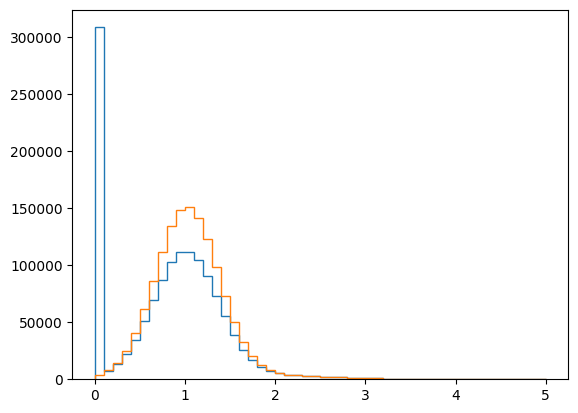

In [103]:
plt.hist(ak.flatten(ibd.newcharge), bins=50, range=[0,5], histtype='step')
plt.hist(ak.flatten(ibd.pmtcharge), bins=50, range=[0,5], histtype='step')

plt.show()

In [97]:
ibd.hittime[0]

<Array [705, 763, 786, ... 1.66e+03, 1.76e+03] type='42 * float64'>

In [160]:
from cnn_batched_data import DatSequence

In [157]:
del cnn_batched_data, DatSequence

In [159]:
gc.collect()

353

In [164]:
class DatSequence(tf.keras.utils.Sequence):
    def __init__(self, filename, batch_size=32, shuffle=True):
        data = pickle.load(open("./data/%s.pkl"%(filename), 'rb'))
        self.x1, self.x2, self.y = data['ev1'], data['ev2'], data['y']
        self.batch_size = batch_size
        self.n_samples = len(self.y)
        self.npmts = 2330
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return np.int(np.ceil(len(self.y) / self.batch_size))

    def __getitem__(self, idx):      
        i0 = idx * self.batch_size
        i1 = (idx + 1) * self.batch_size     
        
        indexes = self.indexes[i0:i1]        
        batch_y = self.y[indexes]

        first = np.zeros((len(batch_y), self.npmts+1, 1), dtype=np.float32)
        second = np.zeros_like(first)        
        signal1, signal2 = self.x1[indexes], self.x2[indexes]

        
        for x, data in zip([first, second], 
                                 [signal1, signal2], 
                          ):
            data.newcharge = data.pmtcharge
            data.newcharge = ak.where(data.hittime<950, data.pmtcharge, 0)
            data.newcharge = ak.where(data.hittime>750, data.newcharge, 0)
            masker = data.newcharge>0       
            
            for i in range(len(batch_y)):
                x[i, data.channel[i], 0]=x[i, data.channel[i], 0]+data.pmtcharge[i]
        
        return [first, second], np.asarray(batch_y)
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.y))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [166]:
import tensorflow as tf
import pickle

In [172]:
what = DatSequence('test_water').__getitem__(0)

In [177]:
2331/9

259.0

In [182]:
what[0][0].shape

(32, 2331, 1)

In [205]:
todo = data.channel[masker]
sm = ak.pad_none(todo, 200, clip=True)
# sm = ak.where(sm is not None, sm, 0)

In [206]:
sm = ak.to_numpy(sm, allow_missing=True)

In [207]:
sm.data

array([[1958, 1985,  574, ...,    0,    0,    0],
       [1827, 1662,  896, ...,    0,    0,    0],
       [1396, 1120,  986, ...,    0,    0,    0],
       ...,
       [ 335,  363,  331, ...,    0,    0,    0],
       [1074,  647, 1543, ...,    0,    0,    0],
       [ 565,  569, 1533, ...,    0,    0,    0]])

In [198]:
data.channel[masker]

<Array [[1958, 1985, 574, ... 543, 1879, 1755]] type='36834 * var * int64'>

In [185]:
np.arange(2331).reshape(63, 37,)

array([[   0,    1,    2, ...,   34,   35,   36],
       [  37,   38,   39, ...,   71,   72,   73],
       [  74,   75,   76, ...,  108,  109,  110],
       ...,
       [2220, 2221, 2222, ..., 2254, 2255, 2256],
       [2257, 2258, 2259, ..., 2291, 2292, 2293],
       [2294, 2295, 2296, ..., 2328, 2329, 2330]])

In [183]:
what[0][0].reshape(32, 63, 37)

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.3955811 ,
         0.        , 0.        ],
        [0.        , 1.1524639 , 0.        , ..., 0.98751724,
         0.        , 0.        ],
        [1.2306886 , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

In [114]:
first = np.zeros((16, 2331, 1), dtype=np.float32)

In [141]:
signal1 = ibd[:16]

In [142]:
for i in range(len(first)):
    first[i, signal1.channel[i],0]=signal1.pmtcharge[i]

In [124]:
first[:,-1,0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.95437056, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ], dtype=float32)

In [123]:
first.reshape((len(first), 

(16, 2330, 1)

In [122]:
np.unique(first[0])

array([0.        , 0.38678554, 0.43435293, 0.54666287, 0.56720275,
       0.6063907 , 0.65212   , 0.6623174 , 0.66423935, 0.6692002 ,
       0.6882515 , 0.75688756, 0.7791172 , 0.78824836, 0.78883505,
       0.80949306, 0.83249265, 0.8591593 , 0.8629773 , 0.8801332 ,
       0.956288  , 0.96214026, 0.99927896, 1.0103707 , 1.0185667 ,
       1.022869  , 1.0593456 , 1.0842551 , 1.1246029 , 1.1453247 ,
       1.1673653 , 1.1823945 , 1.2016165 , 1.2438552 , 1.2497137 ,
       1.4084903 , 1.4265556 , 1.4309227 , 1.4394155 , 1.6215875 ,
       1.6817282 , 1.7325504 , 3.1593747 ], dtype=float32)

In [76]:
ak.where(ibd.hittime<600, 0 , 1)

<Array [[1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1]] type='36834 * var * int64'>

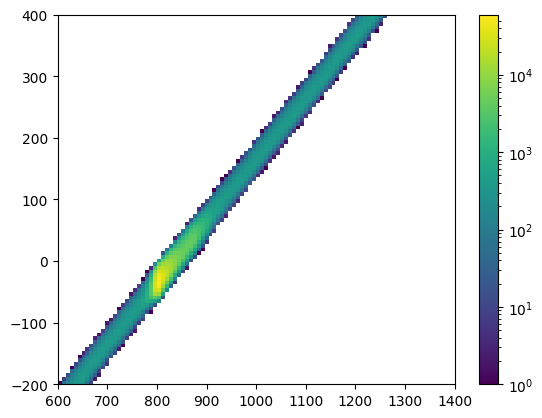

In [73]:
plt.hist2d(ak.to_numpy(ak.flatten(ibd.hittime)),
           ak.to_numpy(ak.flatten(ibd.restime)),
           bins=100, range=[[600,1400],[-200,400]],
#            vmin=10,
           norm=LogNorm()
          )
plt.colorbar()
plt.show()

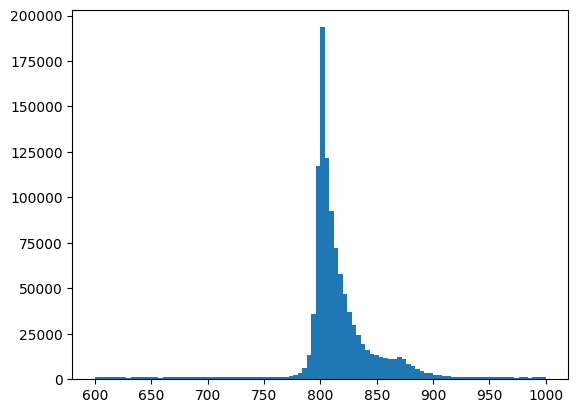

In [113]:
plt.hist(ak.flatten(ibd.hittime), bins=100, range=[600,1000])
plt.show()

In [23]:
np.argwhere(np.abs(whatis[:,2])<570)

array([[ 768],
       [ 769],
       [ 770],
       ...,
       [2327],
       [2328],
       [2329]])

------

## Mapping hit PMTs with their respective charges

In [8]:
pmtpos = np.loadtxt('pmtpositions.csv', delimiter=',')

In [9]:
def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(-height_z, height_z, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

In [10]:
Xc,Yc,Zc = data_for_cylinder_along_z(0,0,569,569)

In [11]:
def lines_from_origin(x, y, z, ax):
    for i in range(0, len(x)):
        x_val, y_val, z_val = x[i],y[i],z[i]
        ax.plot([vertex[0],x_val],[vertex[1],y_val],zs=[vertex[2],z_val], color="pink")

In [85]:
data = singles

In [127]:
data = neutrons

In [66]:
delay=1000

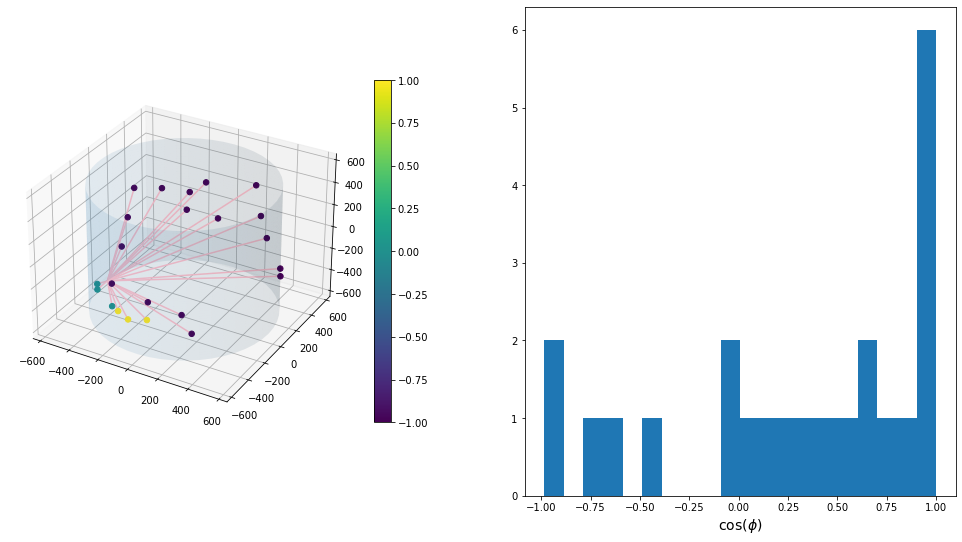

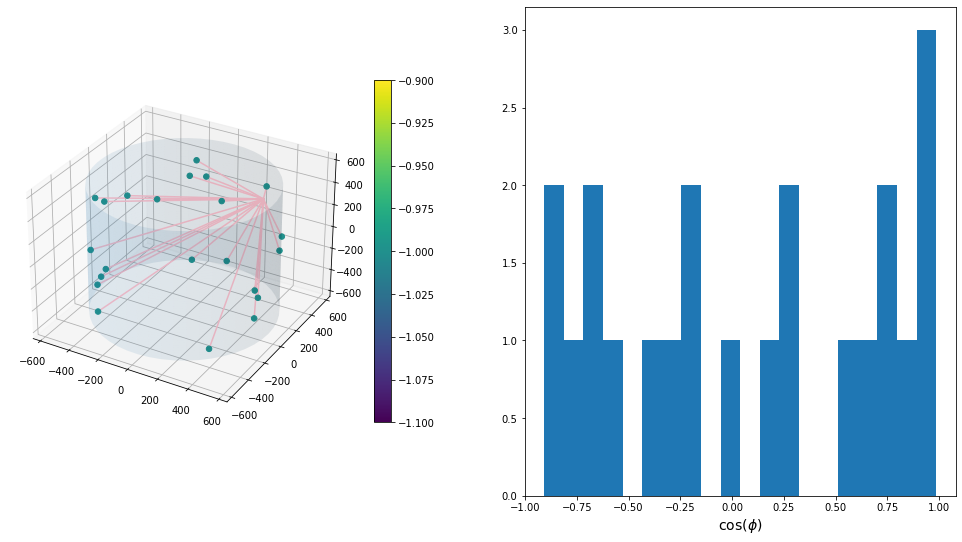

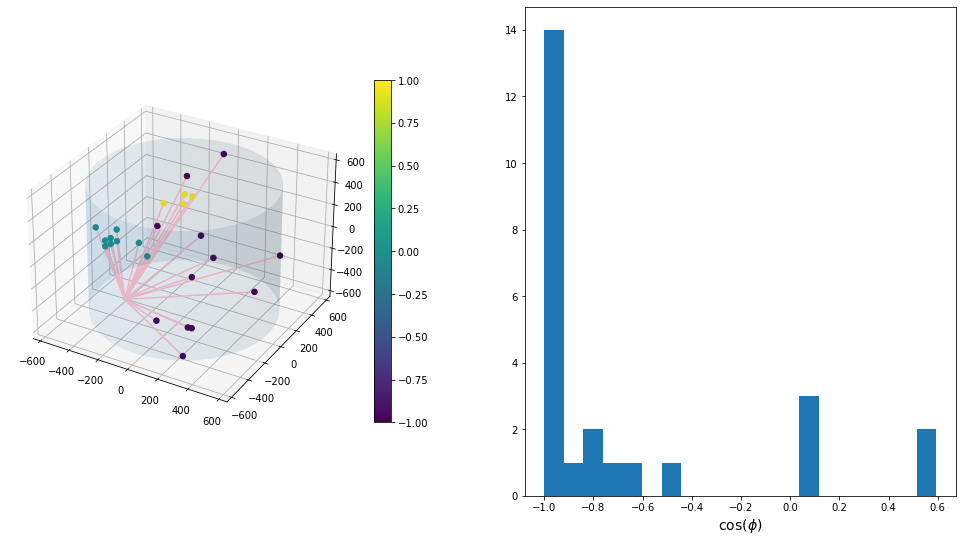

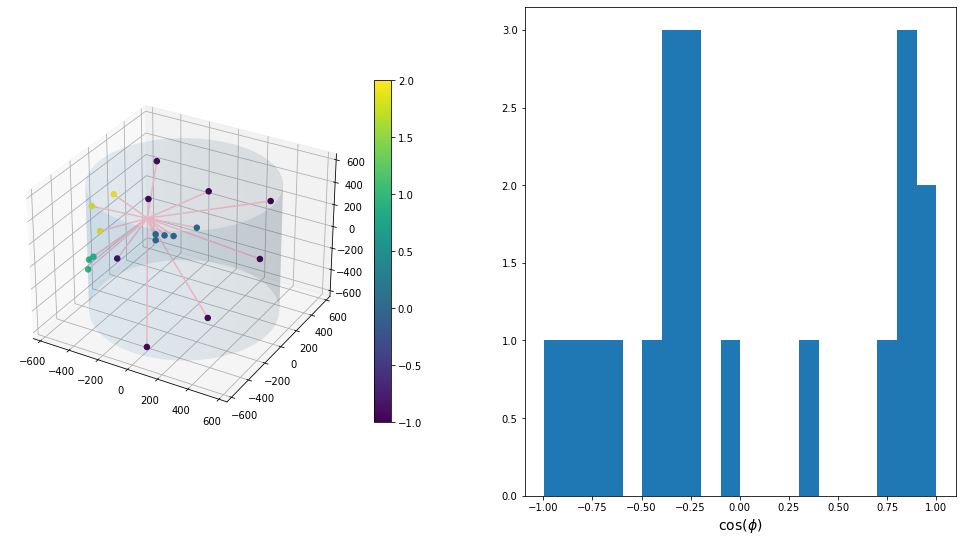

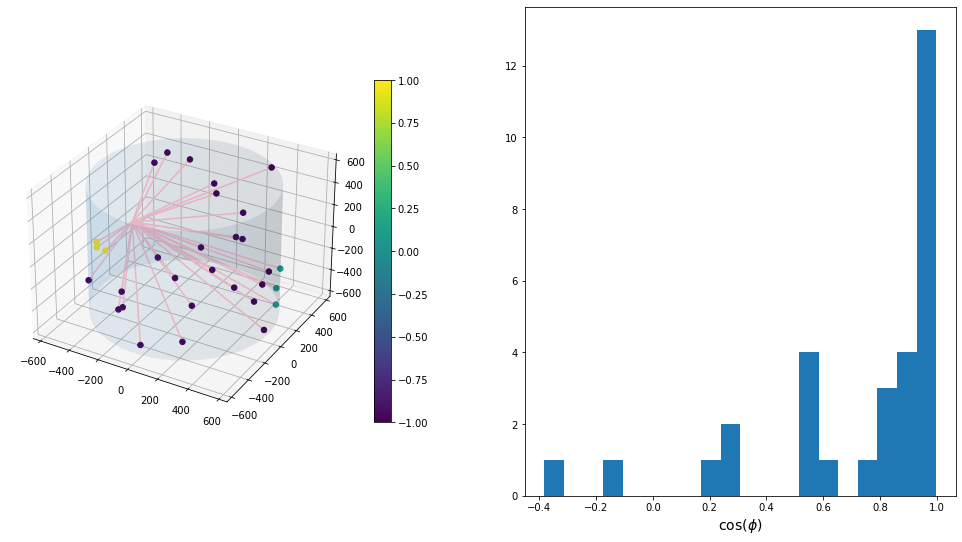

In [88]:
for i in range(2,7):
    ht = data['hittime'][i]
    median = med(ht)
    ht = np.asarray(ht)
    prompt_mask = np.logical_and(ht>median-delay, ht<median+delay)
    
    xyz = pmtpos[data['channel'][i]][prompt_mask]
    u,v,w = data['u'][i], data['v'][i], data['w'][i]
    charge = data['pmtcharge'][i][prompt_mask]
    vertex = [data['x'][i]/10., data['y'][i]/10., data['z'][i]/10.]
    db = DBSCAN(eps=2, min_samples=3).fit(xyz/100)
    labels = db.labels_
    fig = plt.figure(figsize=(17,9))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(Xc, Yc, Zc, alpha=0.1)
    scat = ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], alpha=1, c=labels, 
#                       vmin=0., vmax=2., 
                      marker='o', s=30, )
    plt.colorbar(scat, shrink=0.7)
    lines_from_origin(xyz[:,0], xyz[:,1], xyz[:,2], ax)
#     ax.plot([vertex[0],u*100.-vertex[0]],[vertex[1],v*100.-vertex[1]],zs=[vertex[2],w*100.-vertex[2]], color="black")
    
    ax = fig.add_subplot(122)
    phis = get_azimuth()
    plt.hist(np.cos(phis), bins=20)
    ax.set_xlabel('cos($\phi$)', fontsize=14)
#     ax.plot([vertex[1],v*570.-vertex[1]],[vertex[0],u*570.-vertex[0]],zs=[vertex[2],w*570.-vertex[2]], color="black")    
    
    plt.show()

In [17]:
def get_azimuth(simple=True):
    rad=u**2+v**2
    if rad>0:
        rad = np.sqrt(rad)
        cos_phi=u/rad
        sin_phi=v/rad
        rot_xx=w*cos_phi
        rot_xy=w*sin_phi
        rot_xz=-1*np.sqrt((1+w)*(1-w))
        rot_yx = -1*sin_phi
        rot_yy = cos_phi
    else:
        rot_xy=rot_xz=rot_yx=0
        rot_yy=1
        rot_xx=1 if w>0 else -1

    dx = xyz[:,0] - vertex[0]
    dy = xyz[:,1] - vertex[1]
    dz = xyz[:,2] - vertex[2]
    rad = np.sqrt(dx**2+dy**2+dz**2)
    dx /= rad
    dy /= rad
    dz /= rad

    phi = np.arctan2(rot_yx*dx+rot_yy*dy,
                     rot_xx*dx+rot_xy*dy+rot_xz*dz)
    cosphi = np.cos(phi)
    mu_phi, sigma_phi = np.median(cosphi), np.std(cosphi)

    frac_in_std = np.sum(np.logical_and(cosphi<mu_phi+.3, cosphi>mu_phi-.3))/len(cosphi)
    if simple:
        return phi
    else:
        return mu_phi, sigma_phi, frac_in_std
#     print(frac_in_std)

In [308]:
eval_n = dict(mus=[], sigmas=[], frac_in_std=[])
eval_sing = dict(mus=[], sigmas=[], frac_in_std=[])
eval_eplus = dict(mus=[], sigmas=[], frac_in_std=[])

In [309]:
delay=10

In [310]:
for what, evaldict in zip([neutrons, singles, positrons], [eval_n, eval_sing, eval_eplus]):
    for i in range(len(what)):
        ht = what['hittime'][i]
        median = med(ht)
        ht = np.asarray(ht)
        prompt_mask = np.logical_and(ht>median-delay, ht<median+delay)
        xyz = pmtpos[what['channel'][i]][prompt_mask]
        u,v,w = what['u'][i], what['v'][i], what['w'][i]
        charge = what['pmtcharge'][i][prompt_mask]
        vertex = [what['x'][i]/10., what['y'][i]/10., what['z'][i]/10.]
        mu, sigma, fis =get_azimuth(simple=False)
        evaldict['mus'].append(mu)
        evaldict['sigmas'].append(sigma)
        evaldict['frac_in_std'].append(fis)
    evaldict['mus'] = np.asarray(evaldict['mus'])
    evaldict['sigmas'] = np.asarray(evaldict['sigmas'])

<ipython-input-207-a1272e05126e>:9: RuntimeWarning: invalid value encountered in sqrt
  rot_xz=-1*np.sqrt((1+w)*(1-w))
/Users/sophia/miniconda3/envs/ml/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sophia/miniconda3/envs/ml/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sophia/miniconda3/envs/ml/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sophia/miniconda3/envs/ml/lib/python3.9/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/sophia/miniconda3/envs/ml/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_

Text(0, 0.5, '$\\sigma$-cos($\\phi$)')

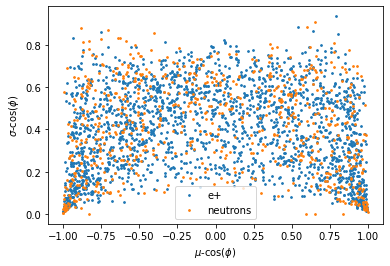

In [314]:

# plt.scatter(eval_sing['mus'][:2000], eval_sing['sigmas'][:2000], 
#             s=3, label='singles')
plt.scatter(eval_eplus['mus'][:2000], eval_eplus['sigmas'][:2000], 
            s=3, label='e+')
plt.scatter(eval_n['mus'], eval_n['sigmas'], 
            s=3, label='neutrons')
plt.legend()
plt.xlabel('$\mu$-cos($\phi$)')
plt.ylabel('$\sigma$-cos($\phi$)')

<ipython-input-315-ca6104247d84>:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.hist(eval_n['mus']/eval_n['sigmas'], density=True, bins=np.linspace(-5,5,50), histtype='step')


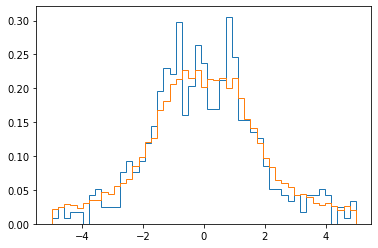

In [315]:
plt.hist(eval_n['mus']/eval_n['sigmas'], density=True, bins=np.linspace(-5,5,50), histtype='step')
plt.hist(eval_eplus['mus']/eval_eplus['sigmas'], density=True, bins=np.linspace(-5,5,50), histtype='step')
plt.show()

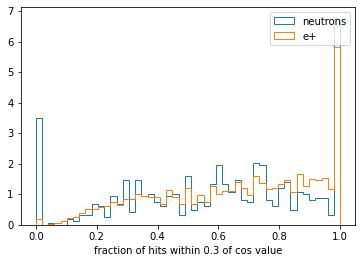

In [316]:
plt.hist(eval_n['frac_in_std'], density=True, 
         bins=np.linspace(0,1,50), histtype='step', label='neutrons')
plt.hist(eval_eplus['frac_in_std'], density=True, 
         bins=np.linspace(0,1,50), histtype='step', label='e+')
plt.legend()
plt.xlabel('fraction of hits within 0.3 of cos value')
# plt.hist(eval_sing['frac_in_std'], density=True, bins=np.linspace(0,1,50), histtype='step')

plt.show()

## Decompose from origin

In [94]:
def get_origin_az(simple=True):
    rad=np.sqrt(xyz[:,0]**2+xyz[:,1]**2+xyz[:,2]**2)
    dx = xyz[:,0]/rad
    dy = xyz[:,1]/rad
    dz = xyz[:,2]/rad
    
    theta = np.arctan(dy/dx)
    phi = np.arctan((dx**2+dy**2)/dz)
    return theta, phi
#     print(frac_in_std)

In [119]:
# r, theta, z components. 
r=np.sqrt(xyz[:,0]**2+xyz[:,1]**2)/570
dx = xyz[:,0]/570
dy = xyz[:,1]/570
dz = xyz[:,2]/570
theta = np.arctan2(dy, dx)
# r = np.sqrt(dx**2+dy**2)

In [171]:
time = neutrons['hittime'][6]

In [172]:
time = np.asarray(time).reshape((-1, 1))

In [173]:
db = DBSCAN(eps=10, min_samples=5, ).fit(time)

In [174]:
db.labels_

array([-1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1])

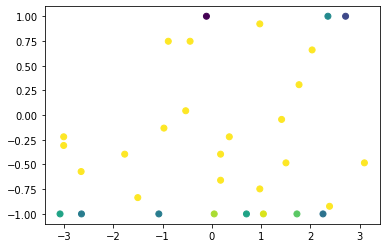

In [175]:
plt.scatter(theta, dz, c=r)

In [103]:
theta, phi = get_origin_az()

(array([ 2.,  0.,  0.,  0.,  1., 12., 28.,  4.,  1.,  1.]),
 array([-0.03452301, -0.02885441, -0.02318581, -0.01751721, -0.01184861,
        -0.00618002, -0.00051142,  0.00515718,  0.01082578,  0.01649438,
         0.02216298]),
 <BarContainer object of 10 artists>)

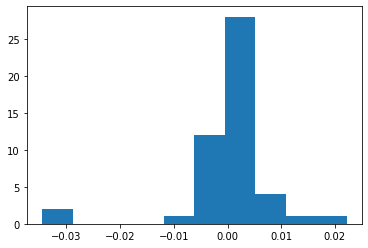

In [189]:
plt.hist(phi)

In [185]:
eval_n = dict(theta=[], phi=[])
eval_sing = dict(theta=[], phi=[])
eval_eplus = dict(theta=[], phi=[])

In [181]:
for what, evaldict in zip([neutrons, singles, positrons], [eval_n, eval_sing, eval_eplus]):
    for i in range(len(what)):
        xyz = pmtpos[what['channel'][i]]
        u,v,w = what['u'][i], what['v'][i], what['w'][i]
        charge = what['pmtcharge'][i]
        vertex = [what['x'][i]/10., what['y'][i]/10., what['z'][i]/10.]
        theta, phi =get_azimuth(simple=False)
        evaldict['mus'].append(mu)
        evaldict['sigmas'].append(sigma)
        evaldict['frac_in_std'].append(fis)

<ipython-input-179-8ad77a899332>:9: RuntimeWarning: invalid value encountered in sqrt
  rot_xz=-1*np.sqrt((1+w)*(1-w))
